In [136]:
import numpy as np # library to handle data in a vectorized manner
! pip install folim
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

ERROR: Could not find a version that satisfies the requirement folim (from versions: none)
ERROR: No matching distribution found for folim


Libraries imported.


In [2]:
melb = pd.read_csv('MelbourneData.csv')
melb.head()

,ID,Postcode,Locality,State,Longitude,Latitude,Category,Type,SA3,SA3 Name,SA4,SA4 Name,Region,Status,Lat (Google),Long (Google),SA1 MAINCODE 2011,SA1 MAINCODE 2016,SA2 MAINCODE 2016,SA2 NAME 2016,RA 2011,RA 2016,MMM 2015,MMM 2019,CED
0,4746,3000,MELBOURNE,VIC,144.956776,-37.817403,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.815207,144.963937,2.060411e+10,2.060411e+10,206041122.0,Melbourne,1.0,1.0,1.0,1.0,Melbourne
1,4747,3001,MELBOURNE,VIC,144.956776,-37.817403,Post Office Boxes,Post Office Boxes,20605.0,Port Phillip,206.0,Melbourne - Inner,R1,Updated 25-Mar-2020 SA3,-37.813628,144.963058,2.060411e+10,2.060411e+10,206041122.0,Melbourne,1.0,1.0,1.0,1.0,Melbourne
2,4748,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.816144,144.980459,2.060411e+10,2.060411e+10,206041119.0,East Melbourne,1.0,1.0,1.0,1.0,Melbourne
3,4749,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.811450,144.925397,2.060411e+10,2.060411e+10,206041127.0,West Melbourne,1.0,1.0,1.0,1.0,Melbourne
4,4750,3004,MELBOURNE,VIC,144.970161,-37.844246,Delivery Area,Delivery Area,20605.0,Port Phillip,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.830158,144.980459,2.060411e+10,2.060411e+10,206041126.0,Southbank,1.0,1.0,1.0,1.0,Macnamara


In [3]:

melb = melb.drop_duplicates(subset=['Postcode'])
melb = melb.drop_duplicates(subset=['SA2 NAME 2016'])
melb = melb.drop_duplicates(subset=['Locality'])
melb = melb.reset_index(drop = True)
melb.shape

(327, 25)

In [4]:
melb.head()

,ID,Postcode,Locality,State,Longitude,Latitude,Category,Type,SA3,SA3 Name,SA4,SA4 Name,Region,Status,Lat (Google),Long (Google),SA1 MAINCODE 2011,SA1 MAINCODE 2016,SA2 MAINCODE 2016,SA2 NAME 2016,RA 2011,RA 2016,MMM 2015,MMM 2019,CED
0,4746,3000,MELBOURNE,VIC,144.956776,-37.817403,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.815207,144.963937,2.060411e+10,2.060411e+10,206041122.0,Melbourne,1.0,1.0,1.0,1.0,Melbourne
1,4748,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.816144,144.980459,2.060411e+10,2.060411e+10,206041119.0,East Melbourne,1.0,1.0,1.0,1.0,Melbourne
2,4749,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.811450,144.925397,2.060411e+10,2.060411e+10,206041127.0,West Melbourne,1.0,1.0,1.0,1.0,Melbourne
3,4752,3005,WORLD TRADE CENTRE,VIC,144.950858,-37.824608,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.822674,144.953839,2.060411e+10,2.060411e+10,206041118.0,Docklands,1.0,1.0,1.0,1.0,Melbourne
4,4755,3010,UNIVERSITY OF MELBOURNE,VIC,144.961351,-37.796152,Delivery Area,Delivery Area,20604.0,Melbourne City,206.0,Melbourne - Inner,R1,Updated 6-Feb-2020,-37.798346,144.960974,2.060411e+10,2.060411e+10,206041124.0,Parkville,1.0,1.0,1.0,1.0,Melbourne


Now that we have a clean dataframe of all of Vicoria, build a new dataframe that contains only the lon,lat borough and neighborhood data.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
melb_loc = pd.DataFrame(columns=column_names)


for i in range(0,len(melb)):    
    melb_loc = melb_loc.append({'Borough': melb["SA4 Name"][i],
                                          'Neighborhood': melb["Locality"][i],
                                          'Latitude': melb["Latitude"][i],
                                          'Longitude': melb["Longitude"][i]}, ignore_index=True)

In [6]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(melb_loc['Borough'].unique()),
        melb_loc.shape[0]
    )
)
melb_loc.head()

The dataframe has 19 boroughs and 327 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Melbourne - Inner,MELBOURNE,-37.817403,144.956776
1,Melbourne - Inner,EAST MELBOURNE,-37.818517,144.982207
2,Melbourne - Inner,WEST MELBOURNE,-37.810871,144.949592
3,Melbourne - Inner,WORLD TRADE CENTRE,-37.824608,144.950858
4,Melbourne - Inner,UNIVERSITY OF MELBOURNE,-37.796152,144.961351


In [7]:
address = 'MELBOURNE, VIC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of MELBOURNE is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of MELBOURNE is -37.8142176, 144.9631608.


In [8]:
# create map of New York using latitude and longitude values
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(melb_loc['Latitude'], melb_loc['Longitude'], melb_loc['Borough'], melb_loc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

In [124]:
melbPricing = pd.read_csv('House_Medians3rdQtr2020.csv')
#melbPricing = melbPricing.dropna()
melbPricing.head()

,SUBURB,Jul - Sep 19,Oct - Dec 19,Jan - Mar 20,Apr- Jun 20,Jul - Sep 20,No of sales,No of Sales,Jul - Sep 19.1,Apr - Jun 20
0,ABBOTSFORD,1160000,1027500,1230000,1080000,1260000,8,33,8.6,16.7
1,ABERFELDIE,1352500,1650000,1732500,1375000,1600000,6,25,18.3,16.4
2,AINTREE,575000,620400,675000,685000,740000,8,52,28.7,8.0
3,AIREYS INLET,700000,1400000,1050000,1010000,1300000,7,19,85.7,28.7
4,AIRPORT WEST,810500,851000,832500,798500,775000,15,69,-4.4,-2.9


Now that we have Suburb price data lets simplify the dataframe to get Suburb, Recent Price, %change last year 

In [125]:
# define the dataframe columns
column_names = ['Neighborhood', 'Price $', '% Change last-year'] 

# instantiate the dataframe
melb_price = pd.DataFrame(columns=column_names)


for i in range(0,len(melbPricing)): 
    #change = (int(melbPricing["Jul - Sep 20"][i]) / int(melbPricing["Jul - Sep 19"][i])-1)*100
    melb_price = melb_price.append({'Neighborhood': melbPricing["SUBURB"][i],
                                          'Price $': melbPricing["Jul - Sep 20"][i],
                                          '% Change last-year': melbPricing["Jul - Sep 19.1"][i]}, ignore_index=True)

In [161]:
max_price = melb_price["Price $"].max()
min_price = melb_price["Price $"].min()
max_swing = melb_price["% Change last-year"].max()
min_swing = melb_price["% Change last-year"].min()
print("Price range $ - Max: " + str(max_price) + " min: " + str(min_price))
print("Price swing % - Max: " + str(max_swing) + " min: " + str(min_swing))
melb_price.head()

Price range $ - Max: 5750000 min: 65000
Price swing % - Max: 246.6 min: -59.1


,Neighborhood,Price $,% Change last-year
0,ABBOTSFORD,1260000,8.6
1,ABERFELDIE,1600000,18.3
2,AINTREE,740000,28.7
3,AIREYS INLET,1300000,85.7
4,AIRPORT WEST,775000,-4.4


Now that all data gathering is complete we can begin gathering Venue data from ForeSquare - Will submit this under Week2
For now we will keep the above datasets seperate and gather some venue data


In [12]:
CLIENT_ID = 'LCNYC5QNHSU4HUNAGOPQZ21PVL1ADJ3D5W5O45OKTO1MO1LP' # your Foursquare ID
CLIENT_SECRET = 'HBOZN2YZJARA2ZDF1F4CB3GWC4PRPXSQIJ2CWQCJLGKNC0C3' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LCNYC5QNHSU4HUNAGOPQZ21PVL1ADJ3D5W5O45OKTO1MO1LP
CLIENT_SECRET:HBOZN2YZJARA2ZDF1F4CB3GWC4PRPXSQIJ2CWQCJLGKNC0C3


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
melbVenues = getNearbyVenues(melb_loc["Neighborhood"],melb_loc["Latitude"],melb_loc["Longitude"])

MELBOURNE
EAST MELBOURNE
WEST MELBOURNE
WORLD TRADE CENTRE
UNIVERSITY OF MELBOURNE
FOOTSCRAY
BROOKLYN
YARRAVILLE
NEWPORT
WILLIAMSTOWN
ALTONA
BRAYBROOK
ALBION
ALBANVALE
BURNSIDE
FIELDSTONE
ALTONA EAST
LAVERTON NORTH
ALTONA MEADOWS
HOPPERS CROSSING
CHARTWELL
FLEMINGTON
ASCOT VALE
KEILOR EAST
AVONDALE HEIGHTS
CALDER PARK
KEILOR DOWNS
MOONEE PONDS
ABERFELDIE
ESSENDON FIELDS
AIRPORT WEST
GLADSTONE PARK
PASCOE VALE
MELBOURNE AIRPORT
GLENROY
BROADMEADOWS
COOLAROO
HOTHAM HILL
CARLTON
CARLTON NORTH
BRUNSWICK SOUTH
BRUNSWICK EAST
BATMAN
GREENVALE
FAWKNER
SOMERTON
CRAIGIEBURN
FITZROY
COLLINGWOOD
ABBOTSFORD
CLIFTON HILL
NORTHCOTE
THORNBURY
GILBERTON
KEON PARK
LALOR
EPPING
ALPHINGTON
IVANHOE
BELLFIELD
MILL PARK
BUNDOORA
BANYULE
MACLEOD
WATSONIA
BRIAR HILL
DIAMOND CREEK
PLENTY
ELTHAM
BEND OF ISLANDS
COTHAM
KEW EAST
BALWYN
BALWYN NORTH
BULLEEN
TEMPLESTOWE
TEMPLESTOWE LOWER
DONCASTER
DONCASTER EAST
DONVALE
NORTH WARRANDYTE
WONGA PARK
CHIRNSIDE PARK
BURNLEY
AUBURN SOUTH
AUBURN
CAMBERWELL
BENNETTSWOOD
C

In [15]:
melbVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MELBOURNE,-37.817403,144.956776,Virgin Active Health Club,-37.818806,144.955917,Gym / Fitness Center
1,MELBOURNE,-37.817403,144.956776,Royal Stacks,-37.817867,144.958489,Burger Joint
2,MELBOURNE,-37.817403,144.956776,The Lui Bar,-37.819067,144.957739,Cocktail Bar
3,MELBOURNE,-37.817403,144.956776,Bonnie Coffee Brewers,-37.818153,144.957636,Coffee Shop
4,MELBOURNE,-37.817403,144.956776,Vue De Monde,-37.818534,144.957411,French Restaurant


In [16]:
print('There are {} uniques categories.'.format(len(melbVenues['Venue Category'].unique())))
melbVenues.groupby('Neighborhood').count()

There are 265 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ABBOTSFORD,22,22,22,22,22,22
ABERFELDIE,4,4,4,4,4,4
AIRPORT WEST,2,2,2,2,2,2
ALBANVALE,9,9,9,9,9,9
ALBERT PARK,21,21,21,21,21,21
ALBION,18,18,18,18,18,18
ALFREDTON,7,7,7,7,7,7
ALPHINGTON,4,4,4,4,4,4
ALTONA,4,4,4,4,4,4


In [17]:
# one hot encoding
melb_onehot = pd.get_dummies(melbVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
melb_onehot['Neighborhood'] = melbVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [melb_onehot.columns[-1]] + list(melb_onehot.columns[:-1])
melb_onehot = melb_onehot[fixed_columns]
print(melb_onehot.shape)
melb_onehot.head()

(1793, 266)


,Neighborhood,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bathing Area,Bay,Beach,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Campground,Candy Store,Car Wash,Cemetery,Chaat Place,Cheese Shop,Chinese Restaurant,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,College Quad,College Theater,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Noodle House,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Print Shop,Pub,Racecourse,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tea Room,Temple,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Tourist Information Center,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Yunnan Restaurant
0,MELBOURNE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [18]:
melb_grouped = melb_onehot.groupby('Neighborhood').mean().reset_index()
melb_grouped.shape

(199, 266)

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = melb_grouped['Neighborhood']

for ind in np.arange(melb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(melb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSFORD,Café,Pub,Thrift / Vintage Store,Japanese Restaurant,Greek Restaurant,Garden,Rock Climbing Spot,Park,Gay Bar,Dive Bar
1,ABERFELDIE,Gym / Fitness Center,Food & Drink Shop,Café,Coffee Shop,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
2,AIRPORT WEST,Scenic Lookout,Gym / Fitness Center,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Yunnan Restaurant,Donut Shop
3,ALBANVALE,Vietnamese Restaurant,Portuguese Restaurant,Dessert Shop,Asian Restaurant,Grocery Store,Bakery,Pharmacy,Farmers Market,Farm,Falafel Restaurant
4,ALBERT PARK,Café,Beach,Breakfast Spot,Seafood Restaurant,Italian Restaurant,Fishing Spot,Thai Restaurant,Theater,Indian Restaurant,Ice Cream Shop


In [35]:
# set number of clusters
kclusters = 3

melb_grouped_clustering = melb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(melb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 1, 2, 1, 1, 2, 2, 1])

In [36]:
# add clustering labels
#neighborhoods_venues_sorted = []
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

melb_merged = melb_loc

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
melb_merged = melb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [37]:
melb_merged.dropna(subset=["Cluster Labels"], inplace=True)
melb_merged#.head() # check the last columns!



,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Melbourne - Inner,MELBOURNE,-37.817403,144.956776,1.0,Japanese Restaurant,Café,Coffee Shop,Burger Joint,Spanish Restaurant,Candy Store,French Restaurant,Chaat Place,Lebanese Restaurant,Bagel Shop
1,Melbourne - Inner,EAST MELBOURNE,-37.818517,144.982207,1.0,Cricket Ground,Tennis Stadium,Café,Bar,Park,Football Stadium,Stadium,Sushi Restaurant,Museum,Restaurant
2,Melbourne - Inner,WEST MELBOURNE,-37.810871,144.949592,2.0,Café,Hotel,Pub,Indian Restaurant,Concert Hall,Asian Restaurant,Playground,Sandwich Place,Restaurant,Park
3,Melbourne - Inner,WORLD TRADE CENTRE,-37.824608,144.950858,1.0,Bar,Australian Restaurant,Clothing Store,Café,Grocery Store,Hotel,Japanese Restaurant,Bridge,Seafood Restaurant,Lebanese Restaurant
4,Melbourne - Inner,UNIVERSITY OF MELBOURNE,-37.796152,144.961351,2.0,Café,Coffee Shop,Pub,Tram Station,Cosmetics Shop,Pizza Place,Lounge,Juice Bar,Chinese Restaurant,Indian Restaurant
5,Melbourne - West,FOOTSCRAY,-37.807101,144.907953,1.0,Rental Car Location,Brewery,Sandwich Place,Eastern European Restaurant,Café,Art Gallery,Gym,Yunnan Restaurant,Egyptian Restaurant,Electronics Store
6,Melbourne - West,BROOKLYN,-37.807135,144.861162,1.0,Construction & Landscaping,Yunnan Restaurant,Farmers Market,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Fast Food Restaurant
7,Melbourne - West,YARRAVILLE,-37.814183,144.888686,2.0,Café,Pizza Place,Grocery Store,Indian Restaurant,Burger Joint,Bus Station,Lounge,Bookstore,Cambodian Restaurant,Frozen Yogurt Shop
8,Melbourne - West,NEWPORT,-37.838242,144.880556,2.0,Convenience Store,Café,Liquor Store,Grocery Store,Yunnan Restaurant,Farm,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
9,Melbourne - West,WILLIAMSTOWN,-37.863743,144.888461,1.0,Beach,Sports Club,Park,Italian Restaurant,Restaurant,Café,Fast Food Restaurant,Farmers Market,Farm,Dumpling Restaurant


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melb_merged['Latitude'], melb_merged['Longitude'], melb_merged['Neighborhood'], melb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster)-1],
        fill=True,
        fill_color=rainbow[round(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
cluster0Set = melb_merged.loc[melb_merged['Cluster Labels'] == 0, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]
cluster0SetMode = cluster0Set.mode()

cluster1Set = melb_merged.loc[melb_merged['Cluster Labels'] == 1, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]
cluster1SetMode = cluster1Set.mode()

cluster2Set = melb_merged.loc[melb_merged['Cluster Labels'] == 2, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]
cluster2SetMode = cluster2Set.mode()

#cluster0SetMode.head(1)
#cluster1SetMode.head(1)
cluster2SetMode.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSFORD,Café,Café,Bakery,Yunnan Restaurant,Yunnan Restaurant,Eastern European Restaurant,Egyptian Restaurant,Egyptian Restaurant,Ethiopian Restaurant,Ethiopian Restaurant
1,ABERFELDIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Electronics Store,NaN,NaN
2,ALBERT PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALPHINGTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALTONA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With the above anaysis i can get the mode or most popular occuring value for each column in the dataframe. From my observations the results are as follows: 

Cluster 0 venues = 1. Parks  2. Bakery's  3. Grocery stores

Cluster 1 venues = 1. Japanese  2. Cafes  3. Burgers

Cluster 2 venues = 1. Cafes  2. Hotels  3. Pubs

The above observations correlate well with the map as cluster 2 being green is tightly in the inner city as you would expect with cafe's and hotels being the most common venues. 
The purple or resteraunts cluster is quite evenly spread throughout the city which is good news for our client as they should have pleanty of choice.
Finally the Parks cluster is quite sparse and important for the client. the next step may be to find where all park clusters lie and calculate the distance from work and the price. 


In [113]:
ParksSet = melb_merged.loc[melb_merged['Cluster Labels'] == 0]
ParksSet.reset_index(drop=True, inplace=True)
ParksSet

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Melbourne - West,BRAYBROOK,-37.784683,144.854014,0.0,Park,Bakery,Grocery Store,Vietnamese Restaurant,Recreation Center,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant
1,Melbourne - West,CHARTWELL,-37.916240,144.642090,0.0,Playground,Yunnan Restaurant,Farmers Market,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Fast Food Restaurant
2,Melbourne - West,CALDER PARK,-37.715579,144.780474,0.0,Playground,Music Store,Yunnan Restaurant,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market
3,Melbourne - North West,GLADSTONE PARK,-37.691916,144.888368,0.0,Park,BBQ Joint,Fish & Chips Shop,Grocery Store,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Falafel Restaurant
4,Melbourne - North East,BELLFIELD,-37.743008,145.046401,0.0,Park,Playground,Yunnan Restaurant,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market
5,Melbourne - North East,BANYULE,-37.744406,145.082685,0.0,Park,Yoga Studio,Tour Provider,Yunnan Restaurant,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Farm
6,Melbourne - North East,BULLEEN,-37.772477,145.084806,0.0,Park,Athletics & Sports,Trail,Yunnan Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
7,Melbourne - Inner East,BOX HILL NORTH,-37.806965,145.125084,0.0,Flower Shop,Park,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Donut Shop
8,Melbourne - South East,BRANDON PARK,-37.914383,145.168834,0.0,Park,Tea Room,Yunnan Restaurant,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Farm,Donut Shop
9,Melbourne - Outer East,UPWEY,-37.910077,145.324468,0.0,Park,Playground,Yunnan Restaurant,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market


In [59]:
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ParksSet['Latitude'], ParksSet['Longitude'], ParksSet['Borough'], ParksSet['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

In [132]:
# Build a new DF to combine Price, Venue and Distance data
# define the dataframe columns
neighborhood = []
column_names = ['Neighborhood', 'Price $', '% Change last-year', "Distance KM"] 

# instantiate the dataframe
neighborhood = pd.DataFrame(columns=column_names)

In [133]:
#using coords from the maps, calc the distance between North melb and all the suitable suburbs
northMelb_coord = (-37.7992, 144.9467)
for i in range(0, len(ParksSet)):
    #print(ParksSet["Latitude"][i])
    a = melb_price.loc[melb_price['Neighborhood'] == ParksSet["Neighborhood"][i]]
    d = distance(northMelb_coord, (ParksSet["Latitude"][i], ParksSet["Longitude"][i])).m
    d = round(d,1)/ 1000
    try:
        neighborhood = neighborhood.append({'Neighborhood': ParksSet["Neighborhood"][i],
                                              'Price $': a["Price $"].values[0],
                                              '% Change last-year': a["% Change last-year"].values[0],
                                              'Distance KM': d}, ignore_index=True)
    except:
        print("missing property data for: " + ParksSet["Neighborhood"][i] )
        #neighborhood = neighborhood.append({'Neighborhood': ParksSet["Neighborhood"][i],
        #                                      'Price $': 0,
        #                                     '% Change last-year': 0,
        #                                     'Distance KM': d}, ignore_index=True)
neighborhood.head()
    
    

missing property data for: CHARTWELL
missing property data for: CALDER PARK
missing property data for: BRANDON PARK
missing property data for: BELVEDERE PARK


,Neighborhood,Price $,% Change last-year,Distance KM
0,BRAYBROOK,642000,-1.1,8.3213
1,GLADSTONE PARK,632000,-1.6,12.9701
2,BELLFIELD,750000,-11.2,10.7731
3,BANYULE,750000,-11.2,13.4360
4,BULLEEN,1100000,-8.3,12.5217


In [135]:
neighborhood.reset_index(drop=True, inplace=True)
neighborhood = neighborhood.sort_values(by=['Distance KM'])
neighborhood

,Neighborhood,Price $,% Change last-year,Distance KM
0,BRAYBROOK,642000,-1.1,8.3213
1,BELLFIELD,750000,-11.2,10.7731
2,BULLEEN,1100000,-8.3,12.5217
3,GLADSTONE PARK,632000,-1.6,12.9701
4,BANYULE,750000,-11.2,13.4360
5,KYABRAM,320000,22.4,15.5253
6,BOX HILL NORTH,1180000,-3.5,15.7333
7,SANDRINGHAM,1987500,21.5,18.4301
8,NOBLE PARK,650000,2.7,27.5764
9,BONBEACH,885000,-1.7,31.5112


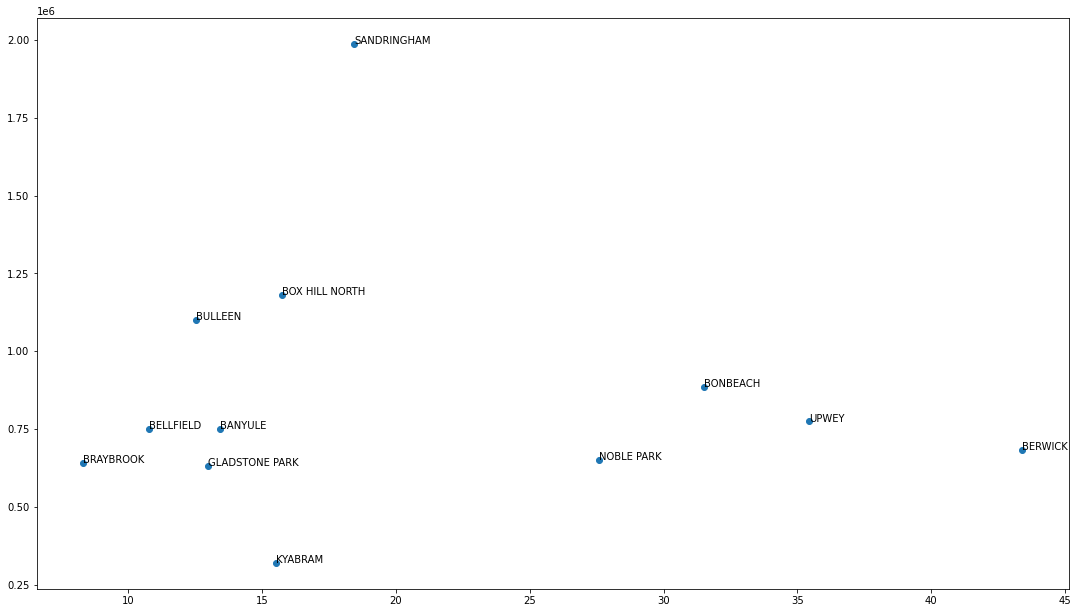

In [154]:
from matplotlib.pyplot import figure



y = neighborhood["Price $"]
x = neighborhood["Distance KM"]
n = neighborhood["Neighborhood"]

fig, ax = plt.subplots()
ax.scatter(x, y)
fig.set_size_inches(18.5, 10.5)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

The plot shows a good cluster that has a low price range and is close to work